# Variable transformation

In [382]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import requests
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

%matplotlib inline

First, let's load in the full X and y dataframes.

In [212]:
with open('data/full_X_y_df.pkl', 'rb') as picklefile:
    [X, y] = pickle.load(picklefile)

We will separate predictors into 3 groups in order to keep track of them.

target: patient status (at time of discharge)

Predictor group 1: Personal demographics
* Age
* Gender
* Race
* Ethnicity
* Primary payer (Medicare, Medicaid, private insurance, etc.)
* Patient location (zip code/county vs public health region)

Predictor group 2: Details about hospital stay
* Day of the week patient admitted (difference between mortality in patients admitted on weekday vs weekend?)
* Type of hospital patient is admitted to; academic vs private vs community vs critical access hospitals
* Length of stay
* Type of admission (urgent vs emergent vs elective)
* Source of admission

Predictor group 3: Medical/procedural
* In-hospital vs out-of-hospital cardiac arrest (presumably, patients who had an admitting diagnosis of cardiac arrest experienced their arrest out-of-hospital, although there may be inaccuracy here if the patient was transferred from another hospital; need to account for this by looking at the source of admission)
* Other associated diagnosis codes, e.g. diabetes, heart failure, etc.
* Other associated procedural codes, e.g. heart surgery, mechanical ventilation, etc.
* Can separate out the associated diagnosis codes to distinguish between the medical conditions that are present on arrival (e.g. chronic conditions) vs medical conditions that develop during the hospital stay.

In [213]:
# target = 'pat_status'
# index = 'record_id'

personal_demographic_predictors = ['pat_age', 'sex_code', 'race', 'ethnicity', 'public_health_region', 'first_payment_src']
hospital_stay_predictors = ['provider_name', 'type_of_admission', 'source_of_admission', 'admit_weekday', 'length_of_stay']

diag_codes_predictors = ['admitting_diagnosis']
diag_codes_predictors.extend([col for col in X.columns if 'diag_code' in col])

e_code_predictors = [col for col in X.columns if 'e_code' in col]

proc_code_predictors = ['princ_surg_proc_code', 'princ_surg_proc_day', 'princ_icd9_code']
proc_code_predictors.extend([col for col in X.columns if 'oth_surg' in col or 'oth_icd9' in col])

## Transform predictor columns

We now have to transform the features of the dataframe into a form where we can actually run our different models on the data set. The majority of the predictor columns are categorical variables, and so we have to use pd.get_dummies (or sklearn onehotencoder) in order to get the dummy variables necessary for the categorical data.

In [4]:
X[personal_demographic_predictors].head()

,pat_age,sex_code,race,ethnicity,public_health_region,first_payment_src
record_id,,,,,,
120110921391,20,M,4,2,07,MA
120110922505,11,F,3,2,07,MA
120110921645,17,F,4,2,07,MA
120110919484,19,F,4,2,07,16
120110919499,16,M,5,1,07,MA


We need to fix the age ranges for patients who have a pat_age of 22 through 26, since they code patients who have HIV or drug/alcohol related diagnoses within broader age ranges. Those ranges are listed below:

* 22: 0-17
* 23: 18-44
* 24: 45-64
* 25: 65-74
* 26: 75+

Therefore, we can map these age ranges to the following:
* 22 -> (encompasses 00 to 05) -> 05 (15-17)
* 23 -> (encompasses 06 to 11) -> 09 (30-34)
* 24 -> (encompasses 12 to 15) -> 14 (50-54)
* 25 -> (encompasses 16 to 17) -> 17 (70-74)
* 26 -> (encompasses 18 to 21) -> 18 (75-79)

We'll also add another flag called 'hiv_drug' which is true for the patients with these values for their patient age, and false for all other patients.

In [5]:
# First we need to make X['pat_age'] numeric.
X['pat_age'] = X['pat_age'].apply(pd.to_numeric)

In [6]:
# Now create a binary variable called 'hiv_drug' and initialize it to 0 for all patients.
X['hiv_drug'] = 0

# For every row where 'pat_age' is greater than 21, set the hiv_drug flag to drue.
X.loc[X['pat_age'] > 21, 'hiv_drug'] = 1

In [7]:
# Now replace the patient ages for the hiv_drug patients with an approximate mapping to another age category.
age_replace_dict = {22: 5, 23: 9, 24: 14, 25: 17, 26: 18}

X = X.replace({'pat_age': age_replace_dict})

Let's go ahead and create the dummified dataframe for the personal demographic predictors.

In [8]:
# Let's go ahead and dummify all of the categorical columns for the personal demographic predictors.
# https://stackoverflow.com/questions/24109779/running-get-dummies-on-several-dataframe-columns

X_demographic_predictors_dummified = \
pd.concat([pd.get_dummies(X[col], prefix=col) for col in personal_demographic_predictors if col != 'pat_age'], axis=1)

In [10]:
# We can add back pat_age to the dummified dataframe, and we can also add back the hiv_drug flag as well to both
# the dataframe and also to the demographic predictors list.
X_demographic_predictors_dummified['pat_age'] = X['pat_age']
X_demographic_predictors_dummified['hiv_drug'] = X['hiv_drug']
personal_demographic_predictors.append('hiv_drug')

In [11]:
X_demographic_predictors_dummified.head()

,sex_code_F,sex_code_M,sex_code_U,race_1,race_2,race_3,race_4,race_5,race_`,ethnicity_1,...,first_payment_src_LM,first_payment_src_MA,first_payment_src_MB,first_payment_src_MC,first_payment_src_OF,first_payment_src_VA,first_payment_src_WC,first_payment_src_ZZ,pat_age,hiv_drug
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,20,0
120110922505,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,11,0
120110921645,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,17,0
120110919484,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,19,0
120110919499,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,16,0


In [292]:
X_demographic_predictors_dummified.columns

Index(['sex_code_F', 'sex_code_M', 'sex_code_U', 'race_1', 'race_2', 'race_3',
       'race_4', 'race_5', 'race_`', 'ethnicity_1', 'ethnicity_2',
       'ethnicity_`', 'public_health_region_01', 'public_health_region_02',
       'public_health_region_03', 'public_health_region_04',
       'public_health_region_05', 'public_health_region_06',
       'public_health_region_07', 'public_health_region_08',
       'public_health_region_09', 'public_health_region_10',
       'public_health_region_11', 'first_payment_src_09',
       'first_payment_src_11', 'first_payment_src_12', 'first_payment_src_13',
       'first_payment_src_14', 'first_payment_src_15', 'first_payment_src_16',
       'first_payment_src_AM', 'first_payment_src_BL', 'first_payment_src_CH',
       'first_payment_src_CI', 'first_payment_src_HM', 'first_payment_src_LM',
       'first_payment_src_MA', 'first_payment_src_MB', 'first_payment_src_MC',
       'first_payment_src_OF', 'first_payment_src_VA', 'first_payment_src_WC',
  

In [293]:
len(X_demographic_predictors_dummified.columns)

45

### Test personal demographics on classifier algorithms.

In reality, X needs to be scaled and centered (at least patient age does), and then you need to also do a train/test split, and to measure the accuracy on cross-validation, but at least we can get a rough idea if the personal demographic information even yields any value.

In [14]:
X_dem_dummies_drop_one = X_demographic_predictors_dummified.drop(['sex_code_U', 'race_`', 'public_health_region_11', 'first_payment_src_ZZ'], axis=1)

In [22]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

0.6874212846347607


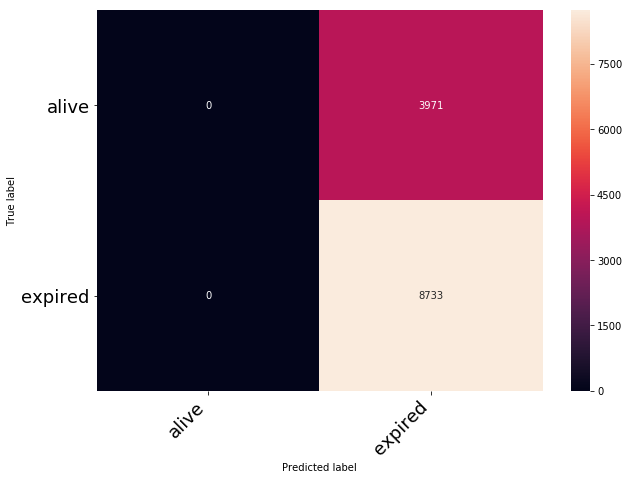

In [26]:
# We'll look at the dummy classifier first.

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_dem_dummies_drop_one, y)
print(dummy_classifier.score(X_dem_dummies_drop_one, y))
y_pred = dummy_classifier.predict(X_dem_dummies_drop_one)
cm = confusion_matrix(y, y_pred)
fig = print_confusion_matrix(cm, ['alive', 'expired'])

0.6845875314861462


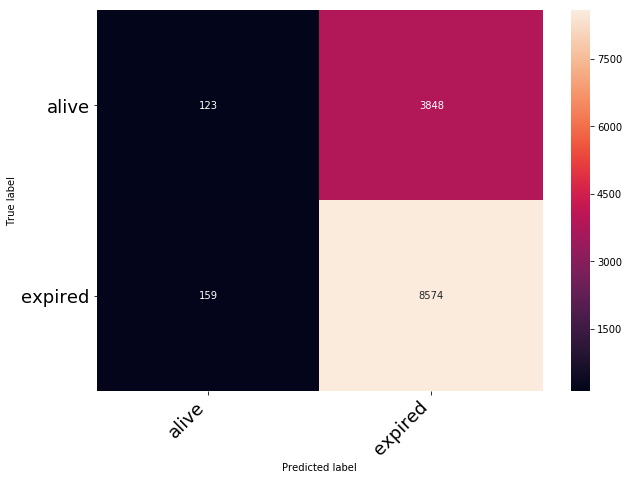

In [27]:
# Now let's look at logistic regression.

logr = LogisticRegression()
logr.fit(X_dem_dummies_drop_one, y)
print(logr.score(X_dem_dummies_drop_one, y))
y_pred = logr.predict(X_dem_dummies_drop_one)
cm = confusion_matrix(y, y_pred)
fig = print_confusion_matrix(cm, ['alive', 'expired'])

0.796205919395466


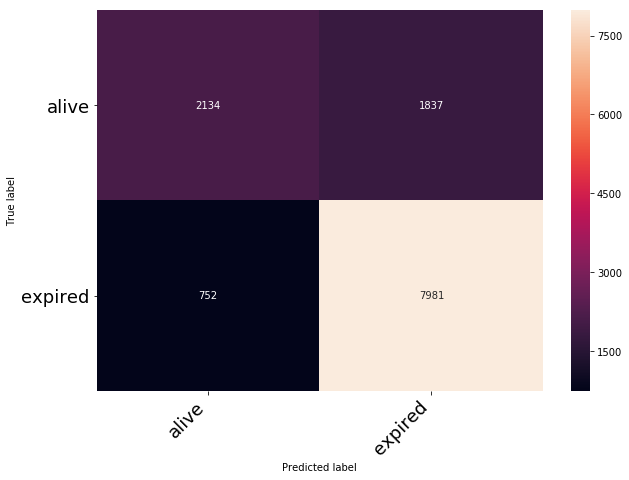

In [28]:
dtc = DecisionTreeClassifier()
dtc.fit(X_demographic_predictors_dummified, y)
print(dtc.score(X_demographic_predictors_dummified, y))

y_pred = dtc.predict(X_demographic_predictors_dummified)
cm = confusion_matrix(y, y_pred)
fig = print_confusion_matrix(cm, ['alive', 'expired'])

0.7900661209068011


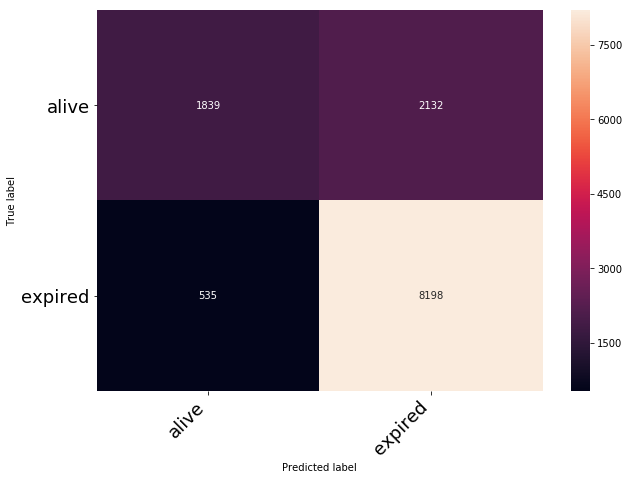

In [29]:
# decision tree classifier actually gives a higher accuracy that random forests; probably need to tune rfc.
rfc = RandomForestClassifier()
rfc.fit(X_demographic_predictors_dummified, y)
print(rfc.score(X_demographic_predictors_dummified, y))

y_pred = rfc.predict(X_demographic_predictors_dummified)
cm = confusion_matrix(y, y_pred)
fig = print_confusion_matrix(cm, ['alive', 'expired'])

### Hospital stay predictors

Now, let's look at the hospital stay predictors and how these columns need to be transformed.

In [214]:
X[hospital_stay_predictors].head()

,provider_name,type_of_admission,source_of_admission,admit_weekday,length_of_stay
record_id,,,,,
120110921391,North Austin Medical Center,1,1,1,0004
120110922505,North Austin Medical Center,1,5,2,0006
120110921645,North Austin Medical Center,1,1,5,0004
120110919484,North Austin Medical Center,1,1,1,0006
120110919499,North Austin Medical Center,1,1,1,0019


There are a few columns we need to fix:
1. Instead of classifier individual providers (hospitals), for a first pass we will instead classify hospitals as academic vs community vs critical access, etc. This will have to come from the facility file to get a mapping for each of the facilities.
2. Change admit weekday into a boolean column called 'weekday'; if the patient was admitted on a weekday, then the value is 1, otherwise if the patient was admitted on a weekend then the value is 0
3. Make length of stay numeric

In [215]:
facilities_q1 = pd.read_csv("data/texas/Facility_type1q2011_tab.txt", sep="\t")

facilities_q1.head()

,THCIC_ID,PROVIDER_NAME,FAC_TEACHING_IND,FAC_PSYCH_IND,FAC_REHAB_IND,FAC_ACUTE_CARE_IND,FAC_SNF_IND,FAC_LONG_TERM_AC_IND,FAC_OTHER_LTC_IND,FAC_PEDS_IND,Unnamed: 10
0,100,Austin State Hospital,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,Big Spring State Hospital,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,102,UT Medical Branch Hospital,A,NaN,X,X,NaN,NaN,NaN,X,NaN
3,104,Rio Grande State Center,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,UT MD Anderson Cancer Center,A,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN


In [216]:
teaching_hospitals_tx = list(facilities_q1['PROVIDER_NAME'][~facilities_q1['FAC_TEACHING_IND'].isnull()])

In [217]:
# List of which hospitals are critical access hospitals obtained from here:
# http://www.flexmonitoring.org/data/critical-access-hospital-locations/historic-cah-data/

CAH_hospitals_from_web = pd.read_excel('data/texas/2011-Mar-CAH-List.xls')

CAH_hospitals_texas_from_web = CAH_hospitals_from_web[CAH_hospitals_from_web['CAHSTATE'] == 'TX']

CAH_texas = list(set(facilities_q1['PROVIDER_NAME']).intersection(set(CAH_hospitals_texas_from_web['CAHNAME'])))

In [218]:
hospital_teaching = np.isin(X['provider_name'], teaching_hospitals_tx)
hospital_CAH = np.isin(X['provider_name'], CAH_texas)

In [219]:
X['hospital_teaching'] = teaching_hospital_flag
X['hospital_CAH'] = CAH_flag

X['hospital_teaching'] = X['hospital_teaching'].apply(int)
X['hospital_CAH'] = X['hospital_CAH'].apply(int)

In [220]:
X['hospital_community'] = X['hospital_CAH'] | X['hospital_teaching']
X['hospital_community'] = X['hospital_community'].apply(lambda x: not(x)).apply(int)

hospital_stay_predictors.extend(['hospital_teaching', 'hospital_CAH', 'hospital_community'])
hospital_stay_predictors.remove('provider_name')

In [221]:
X[hospital_stay_predictors].head()

,type_of_admission,source_of_admission,admit_weekday,length_of_stay,hospital_teaching,hospital_CAH,hospital_community
record_id,,,,,,,
120110921391,1,1,1,0004,0,0,1
120110922505,1,5,2,0006,0,0,1
120110921645,1,1,5,0004,0,0,1
120110919484,1,1,1,0006,0,0,1
120110919499,1,1,1,0019,0,0,1


In [222]:
# Now let's fix admit_weekday. If admit_weekday is 6 or 7, then that means the patient was admitted on a weekend.
# We will therefore set this flag to 0. Otherwise, we will set it equal to 1.

weekday_dict = {'6': 0, '7': 0, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1}

X['admit_weekday'] = X['admit_weekday'].replace(weekday_dict)

In [223]:
# Let's make length_of_stay numeric.
X['length_of_stay'] = X['length_of_stay'].apply(pd.to_numeric)

In [232]:
# And now let's dummify type_of_admission and source_of_admission.
X_hospital_predictors_dummified =\
pd.concat([pd.get_dummies(X[col], prefix=col) for col in hospital_stay_predictors if col in {'type_of_admission', 'source_of_admission'}], axis=1)

In [233]:
hospital_stay_predictors_non_dummies = \
[pr for pr in hospital_stay_predictors if pr not in {'type_of_admission', 'source_of_admission'}]

In [234]:
X_hospital_predictors_df = X_hospital_predictors_dummified.merge(X[hospital_stay_predictors_non_dummies], left_index=True, right_index=True)

In [235]:
print(X_hospital_predictors_df.shape)
print(list(X_hospital_predictors_df.columns))
X_hospital_predictors_df.head()

(12704, 22)
['type_of_admission_1', 'type_of_admission_2', 'type_of_admission_3', 'type_of_admission_4', 'type_of_admission_5', 'type_of_admission_9', 'source_of_admission_1', 'source_of_admission_2', 'source_of_admission_4', 'source_of_admission_5', 'source_of_admission_6', 'source_of_admission_7', 'source_of_admission_8', 'source_of_admission_9', 'source_of_admission_A', 'source_of_admission_D', 'source_of_admission_`', 'admit_weekday', 'length_of_stay', 'hospital_teaching', 'hospital_CAH', 'hospital_community']


,type_of_admission_1,type_of_admission_2,type_of_admission_3,type_of_admission_4,type_of_admission_5,type_of_admission_9,source_of_admission_1,source_of_admission_2,source_of_admission_4,source_of_admission_5,...,source_of_admission_8,source_of_admission_9,source_of_admission_A,source_of_admission_D,source_of_admission_`,admit_weekday,length_of_stay,hospital_teaching,hospital_CAH,hospital_community
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,4,0,0,1
120110922505,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,6,0,0,1
120110921645,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,4,0,0,1
120110919484,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,6,0,0,1
120110919499,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,19,0,0,1


### Diagnosis Codes

Let's deal with the diagnosis codes first. So what we can do is form tuples out of the diagnosis codes and whether or not they are present on arrival (poa is yes vs any other value, e.g. no or none), then create a global dictionary of these tuples and keep a count of how many times those tuples have occurred. Then you can pick the top 10 or 20 tuples that occur most frequently, and then use them as dummy variables (if they are present or absent).

You could also look at 4 different categories of tuple/poa pairs. 1) most common diag code + present on arrival, and pick the chronic conditions, 2) most common diag codes + *not* present on arrival, looking at the things that happen while the patient is in the hospital, and then 3) & 4) pick the top 10 of each for patients who did survive vs patients who did not survive.

In [333]:
# Let's make tuple pairs for each diagnosis and whether or not it was present on arrival, for each
# diagnosis column. First we get the names of the diagnosis columns, and then the names of the poa columns.

diag_codes_cols = (X.filter(regex=r'(^princ_diag)|(^oth_diag)', axis=1)).columns
diag_codes_poa_cols = (X.filter(regex=r'(^poa_princ)|(^poa_oth)', axis=1)).columns

In [334]:
# We'll pair the diag columns with the poa columns and store them as tuples, and then also join the
# paired column names together to come up with the name for the new tuple column.
paired_diag_poa = list(zip(diag_codes_cols, diag_codes_poa_cols))
paired_diag_poa_names = [pair[0] + '_AND_' + pair[1] for pair in paired_diag_poa]

In [335]:
# We'll create a mini-dataframe with the first two columns of X, just so that we can have a frame to add our
# tuple diag/POA columns to.
diag_poa_frame = X[['discharge', 'thcic_id']].copy()

# Iterate through the paired diagnosis/POA column names with an index, and zip those two columns together into
# a new column with that name.
for i, paired_diag_poa_col in enumerate(paired_diag_poa_names):
    diag_poa_frame[paired_diag_poa_col] = list(X[list(paired_diag_poa[i])].itertuples(index=False, name=None))

# Now that we've created the diagnosis/POA tuple columns, we can drop the first two columns copied from X.
diag_poa_frame.drop(['discharge', 'thcic_id'], axis=1, inplace=True)

In [336]:
# Make a list of all the diagnosis tuples by making a list of all rows
diag_poa_lists = diag_poa_frame.apply(list, axis=1)

# We now add this list of all the diagnosis/POA tuples as a new column to X.
X['diag_poa_list'] = diag_poa_lists

In [337]:
# We can make a list of lists from the diag/poa tuples for each record.
diag_poas_list_of_lists = X['diag_poa_list'].tolist()

In [338]:
# Let's flatten out the list of lists, and also sort the diagnosis/poa tuples into lists based on whether or not
# they were present on arrival or not. We'll check for both 'Y' and 'N', because a decent number of tuples have
# 'None' as the status for their diagnoses.

not_poa_diags = []
poa_diags = []

for sublist in diag_poas_list_of_lists:
    for item in sublist:
        if item[0]:
            if item[1] == 'Y':
                poa_diags.append(item)
            elif item[1] == 'N':
                not_poa_diags.append(item)

In [339]:
poa_diags_counter = Counter(poa_diags)
not_poa_diags_counter = Counter(not_poa_diags)

N = 20

# We can look at the top N most common present on arrival diagnosis codes:
poa_diags_most_common_dict = dict(poa_diags_counter.most_common(N))

# And we can look at the top N most common *not* present on arrival diagnosis codes:
not_poa_diags_most_common_dict = dict(not_poa_diags_counter.most_common(N))

In [340]:
clinical_tables_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_dx/v3/search?terms={}"

poa_diag_most_common_text_dict = {}

for key, value in poa_diags_most_common_dict.items():
    response = requests.get(clinical_tables_query.format(key[0]))
    val = response.json()
    dx = val[3][0][1].strip()
    poa_diag_most_common_text_dict[dx] = value

not_poa_diag_most_common_text_dict = {}

for key, value in not_poa_diags_most_common_dict.items():
    response = requests.get(clinical_tables_query.format(key[0]))
    val = response.json()
    dx = val[3][0][1].strip()
    if dx in not_poa_diag_most_common_text_dict:
        not_poa_diag_most_common_text_dict[dx] += value
    else:
        not_poa_diag_most_common_text_dict[dx] = value

In [342]:
print("Present on arrival diagnoses:")
display(poa_diag_most_common_text_dict)
print("Not present on arrival diagnoses:")
display(not_poa_diag_most_common_text_dict)

Present on arrival diagnoses:


{'Cardiac arrest': 5052,
 'Acute respiratory failure': 4747,
 'Unspecified essential hypertension': 3722,
 'Congestive heart failure, unspecified': 3525,
 'Coronary atherosclerosis of native coronary artery': 3087,
 'Other and unspecified hyperlipidemia': 2801,
 'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled': 2661,
 'Acute kidney failure, unspecified': 2619,
 'Anoxic brain damage': 2540,
 'Acidosis': 2269,
 'Atrial fibrillation': 2115,
 'Unspecified septicemia': 1738,
 'Anemia, unspecified': 1652,
 'Severe sepsis': 1588,
 'Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified': 1507,
 'End stage renal disease': 1501,
 'Pneumonia, organism unspecified': 1453,
 'Chronic airway obstruction, not elsewhere classified': 1403,
 'Tobacco use disorder': 1401,
 'Unspecified acquired hypothyroidism': 1331}

Not present on arrival diagnoses:


{'Cardiac arrest': 6075,
 'Acute respiratory failure': 2349,
 'Do not resuscitate status': 1340,
 'Acute kidney failure, unspecified': 1134,
 'Acidosis': 886,
 'Unspecified septicemia': 820,
 'Severe sepsis': 788,
 'Anoxic brain damage': 782,
 'Hypopotassemia': 777,
 'Paroxysmal ventricular tachycardia': 723,
 'Pneumonitis due to inhalation of food or vomitus': 682,
 'Hyperosmolality and/or hypernatremia': 635,
 'Septic shock': 627,
 'Ventricular fibrillation': 600,
 'Other specified cardiac dysrhythmias': 596,
 'Pneumonia, organism unspecified': 554,
 'Pulmonary collapse': 547,
 'Cardiogenic shock': 539,
 'Acute posthemorrhagic anemia': 521,
 'Acute kidney failure with lesion of tubular necrosis': 521}

Let's make a flag about whether or not cardiac arrest was present on arrival or not; this will act as a rough marker about whether cardiac arrest was out of hospital or in hospital.

In [343]:
# For each record, look through the diag_poa_list and see if the tuple ('4275', 'Y') is present in the that
# record's list. If it is, then this means that the diagnosis of cardiac arrest was present on arrival, which
# we will assume is an out of hospital cardiac arrest.

X['out_of_hospital_cardiac_arrest'] = [('4275', 'Y') in l for l in X['diag_poa_list']]
X['out_of_hospital_cardiac_arrest'] = X['out_of_hospital_cardiac_arrest'].apply(int)

In [344]:
# Let's look at what diagnoses are the most common present-on-arrival diagnoses.
most_common_poa_dxes = [x[0] for x in list(poa_diags_most_common_dict.keys())]
most_common_poa_dxes_text = [x for x in list(poa_diag_most_common_text_dict.keys())]

dict(zip(most_common_poa_dxes, most_common_poa_dxes_text))

{'4275': 'Cardiac arrest',
 '51881': 'Acute respiratory failure',
 '4019': 'Unspecified essential hypertension',
 '4280': 'Congestive heart failure, unspecified',
 '41401': 'Coronary atherosclerosis of native coronary artery',
 '2724': 'Other and unspecified hyperlipidemia',
 '25000': 'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
 '5849': 'Acute kidney failure, unspecified',
 '3481': 'Anoxic brain damage',
 '2762': 'Acidosis',
 '42731': 'Atrial fibrillation',
 '0389': 'Unspecified septicemia',
 '2859': 'Anemia, unspecified',
 '99592': 'Severe sepsis',
 '40390': 'Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified',
 '5856': 'End stage renal disease',
 '486': 'Pneumonia, organism unspecified',
 '496': 'Chronic airway obstruction, not elsewhere classified',
 '3051': 'Tobacco use disorder',
 '2449': 'Unspecified acquired hypothyroidism'}

In [345]:
# Looking at this dictionary mapping the ICD codes, I actually want to keep all of them except for ('4275', 'Y'),
# so I'll remove that from the dictionary.
import copy

dx_flag_dict = copy.deepcopy(poa_diags_most_common_dict)
if ('4275', 'Y') in dx_flag_dict:
    del dx_flag_dict[('4275', 'Y')]

In [346]:
most_common_not_poa_dxes = [x[0] for x in list(not_poa_diags_most_common_dict.keys())]
most_common_not_poa_dxes_text = [x for x in list(not_poa_diag_most_common_text_dict.keys())]

dict(zip(most_common_not_poa_dxes, most_common_not_poa_dxes_text))

{'4275': 'Cardiac arrest',
 '51881': 'Acute respiratory failure',
 'V4986': 'Do not resuscitate status',
 '5849': 'Acute kidney failure, unspecified',
 '2762': 'Acidosis',
 '0389': 'Unspecified septicemia',
 '99592': 'Severe sepsis',
 '3481': 'Anoxic brain damage',
 '2768': 'Hypopotassemia',
 '4271': 'Paroxysmal ventricular tachycardia',
 '5070': 'Pneumonitis due to inhalation of food or vomitus',
 '2760': 'Hyperosmolality and/or hypernatremia',
 '78552': 'Septic shock',
 '42741': 'Ventricular fibrillation',
 '42789': 'Other specified cardiac dysrhythmias',
 '486': 'Pneumonia, organism unspecified',
 '5180': 'Pulmonary collapse',
 '78551': 'Cardiogenic shock',
 '2851': 'Acute posthemorrhagic anemia',
 '5845': 'Acute kidney failure with lesion of tubular necrosis'}

In [350]:
# Looking at this dictionary, I think it makes sense to remove DNR status in addition to cardiac arrest.
# First we'll add the whole dictionary to dx_flag_dict using update, and then remove the cardiac arrest and
# DNR tuples.
dx_flag_dict.update(not_poa_diags_most_common_dict)

if ('4275', 'N') in dx_flag_dict:
    del dx_flag_dict[('4275', 'N')]
    
if ('V4986', 'N') in dx_flag_dict:
    del dx_flag_dict[('V4986', 'N')]

In [423]:
# We'll use the first two columns of X as a frame to create the full diagnoses dataframe.
X_diagnoses_df = copy.deepcopy(X[['thcic_id', 'diag_poa_list']])

In [424]:
# We'll iterate through all of the tuple keys in dx_flag_dict, and if that diagnosis/POA tuple is present in the
# diag_poa_list for that record, then the flag for that diag_tuple is set to true. Otherwise, it's false.
for diag_tuple in list(dx_flag_dict.keys()):
    X_diagnoses_df[diag_tuple] = [diag_tuple in diag_poa_list for diag_poa_list in X_diagnoses_df['diag_poa_list']]

In [425]:
# Now that we've created the full diagnoses/POA dataframe, we can drop the first two columns, and then cast the
# the whole dataframe from boolean type to int.
X_diagnoses_df.drop(['thcic_id', 'diag_poa_list'], axis=1, inplace=True)
X_diagnoses_df = diagnoses_df.astype('int')

In [426]:
# We'll add back out_of_hospital_cardiac_arrest as a flag to the diagnoses_df.
X_diagnoses_df['out_of_hospital_cardiac_arrest'] = X['out_of_hospital_cardiac_arrest']

In [427]:
print(X_diagnoses_df.shape)
X_diagnoses_df.head()

(12704, 38)


,"(51881, Y)","(4019, Y)","(4280, Y)","(41401, Y)","(2724, Y)","(25000, Y)","(5849, Y)","(3481, Y)","(2762, Y)","(42731, Y)",...,"(2760, N)","(78552, N)","(42741, N)","(42789, N)","(486, N)","(5180, N)","(78551, N)","(2851, N)","(5845, N)",out_of_hospital_cardiac_arrest
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110922505,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110921645,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
120110919499,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


### Procedure codes

We should also track the procedure codes that are the most common for patients. This is a similar process as for the diagnosis codes.

In [394]:
proc_codes_cols = (X.filter(regex=r'(icd9_code)', axis=1)).columns
proc_day_cols = (X.filter(regex=r'(proc_day)', axis=1)).columns

paired_proc_day = list(zip(proc_codes_cols, proc_day_cols))
paired_proc_day_names = [pair[0] + '_AND_day' for pair in paired_proc_day]

X[proc_day_cols] = X[proc_day_cols].apply(pd.to_numeric)

In [395]:
proc_day_frame = X[['discharge', 'thcic_id']].copy()

for i, paired_proc_day_col in enumerate(paired_proc_day_names):
    proc_day_frame[paired_proc_day_col] = list(X[list(paired_proc_day[i])].itertuples(index=False, name=None))

proc_day_frame.drop(['discharge', 'thcic_id'], axis=1, inplace=True)

In [396]:
# Make a list of all the procedure tuples by making a list of all rows
proc_day_lists = proc_day_frame.apply(list, axis=1)

# We now add this list of all the diagnosis/POA tuples as a new column to X.
X['proc_day_list'] = proc_day_lists

### Get most common procedures

Steps to get the most common procedures:
1. Make a list of lists of all the procedures
2. Flatten list
3. Create counter object that gets the most common N procedures
4. Look up the value of these procedure codes in ICD 9

In [398]:
# Let's also make a list of all the procedures associated with a particular discharge.
proc_lists = X[proc_codes_cols].apply(list, axis=1)

# Let's get rid of all of the duplicate procedures (which is really getting rid of the multiple None values)
proc_lists = proc_lists.apply(set).apply(list)

# We can then add back the procedure lists to the original dataframe in the 'proc_list' column.
X['proc_list'] = proc_lists

all_proc_list = []

for sublist in proc_lists:
    for item in sublist:
        if item:
            all_proc_list.append(item)

all_proc_count = Counter(all_proc_list)

all_proc_dict = dict(all_proc_count.most_common(30))

clinical_tables_proc_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_sg/v3/search?terms={}"

all_proc_text_dict = {}

for key, value in all_proc_dict.items():
    response = requests.get(clinical_tables_proc_query.format(key))
    val = response.json()
    dx = val[3][0][1].strip()
    all_proc_text_dict[dx] = value

all_proc_text_dict

{'Insertion of endotracheal tube': 7356,
 'Continuous invasive mechanical ventilation for less than 96 consecutive hours': 6208,
 'Cardiopulmonary resuscitation, not otherwise specified': 4933,
 'Venous catheterization, not elsewhere classified': 4672,
 'Transfusion of packed cells': 3107,
 'Continuous invasive mechanical ventilation for 96 consecutive hours or more': 2996,
 'Arterial catheterization': 1945,
 'Hemodialysis': 1763,
 'Coronary arteriography using two catheters': 1746,
 'Left heart cardiac catheterization': 1599,
 'Angiocardiography of left heart structures': 1313,
 'Infusion of vasopressor agent': 1068,
 'Transfusion of other serum': 1041,
 'Central venous catheter placement with guidance': 1013,
 'Percutaneous transluminal coronary angioplasty [PTCA]': 967,
 'Venous catheterization for renal dialysis': 911,
 'Procedure on single vessel': 792,
 'Other electric countershock of heart': 756,
 'Temporary tracheostomy': 653,
 'Transfusion of platelets': 643,
 'Implant of puls

In [ ]:
# We can make a list of lists from the proc/day tuples for each record.
proc_day_list_of_lists = X['proc_day_list'].tolist()

# Let's flatten out the list of lists, and then pick the most common N proc/day tuples that are present.
proc_day_pairs = []

for sublist in proc_day_list_of_lists:
    for item in sublist:
        if item[0]:
            proc_day_pairs.append(item)

proc_day_count = Counter(proc_day_pairs)

proc_day_dict = dict(proc_day_count.most_common(30))

proc_day_dict

clinical_tables_proc_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_sg/v3/search?terms={}"

proc_day_text_dict = {}

for key, value in proc_day_dict.items():
    response = requests.get(clinical_tables_proc_query.format(key[0]))
    val = response.json()
    dx = val[3][0][1].strip()
    proc_day_text_dict[dx] = value

proc_day_text_dict

For now, let's just use the presence/absence of a procedure as a boolean flag, rather than accounting for how long into the stay a particular procedure occurred.

In [418]:
# We'll use the first two columns of X as a frame to create the full diagnoses dataframe.
X_procedures_df = copy.deepcopy(X[['thcic_id', 'proc_list']])

In [419]:
# We'll iterate through all of the tuple keys in dx_flag_dict, and if that diagnosis/POA tuple is present in the
# diag_poa_list for that record, then the flag for that diag_tuple is set to true. Otherwise, it's false.
for proc in list(all_proc_dict.keys()):
    X_procedures_df[proc] = [proc in proc_list for proc_list in X_procedures_df['proc_list']]

In [420]:
# Now that we've created the full procedures dataframe, we can drop the first two columns, and then cast the
# the whole dataframe from boolean type to int.
X_procedures_df.drop(['thcic_id', 'proc_list'], axis=1, inplace=True)
X_procedures_df = procedures_df.astype('int')

### All dataframes

We'll get all the dataframes for the 4 broad groups of predictors that we cleaned up and dummified, and pickle them. We'll also pickle the X dataframe, which we made some modifications to.

In [416]:
X_demographic_predictors_dummified.head()

,sex_code_F,sex_code_M,sex_code_U,race_1,race_2,race_3,race_4,race_5,race_`,ethnicity_1,...,first_payment_src_LM,first_payment_src_MA,first_payment_src_MB,first_payment_src_MC,first_payment_src_OF,first_payment_src_VA,first_payment_src_WC,first_payment_src_ZZ,pat_age,hiv_drug
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,20,0
120110922505,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,11,0
120110921645,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,17,0
120110919484,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,19,0
120110919499,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,16,0


In [417]:
X_hospital_predictors_df.head()

,type_of_admission_1,type_of_admission_2,type_of_admission_3,type_of_admission_4,type_of_admission_5,type_of_admission_9,source_of_admission_1,source_of_admission_2,source_of_admission_4,source_of_admission_5,...,source_of_admission_8,source_of_admission_9,source_of_admission_A,source_of_admission_D,source_of_admission_`,admit_weekday,length_of_stay,hospital_teaching,hospital_CAH,hospital_community
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,4,0,0,1
120110922505,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,6,0,0,1
120110921645,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,4,0,0,1
120110919484,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,6,0,0,1
120110919499,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,19,0,0,1


In [429]:
X_diagnoses_df.head()

,"(51881, Y)","(4019, Y)","(4280, Y)","(41401, Y)","(2724, Y)","(25000, Y)","(5849, Y)","(3481, Y)","(2762, Y)","(42731, Y)",...,"(2760, N)","(78552, N)","(42741, N)","(42789, N)","(486, N)","(5180, N)","(78551, N)","(2851, N)","(5845, N)",out_of_hospital_cardiac_arrest
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110922505,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110921645,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
120110919499,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [430]:
X_procedures_df.head()

,9604,9671,9960,3893,9904,9672,3891,3995,8856,3722,...,3761,9390,8872,3607,0045,3324,4311,3404,3961,9915
record_id,,,,,,,,,,,,,,,,,,,,,
120110921391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110922505,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
120110921645,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919484,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120110919499,1,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [433]:
with open('pkls/dem_hosp_dx_proc_orig_X_dfs.pkl', 'wb') as picklefile:
    pickle.dump([X_demographic_predictors_dummified, X_hospital_predictors_df, X_diagnoses_df, X_procedures_df, X], picklefile)